In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

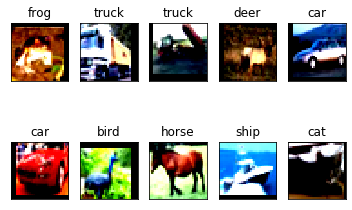

In [4]:
fig = plt.figure()
 
for i in range(10):
    # 2x5 그리드에 i+1번째 subplot을 추가하고 얻어옴
    subplot = fig.add_subplot(2, 5, i + 1)

    # x, y 축의 지점 표시를 안함
    subplot.set_xticks([])
    subplot.set_yticks([])

    # subplot의 제목을 i번째 결과에 해당하는 숫자로 설정
    subplot.set_title('%s' % classes[train_dataset[i][1]])

    # 입력으로 사용한 i번째 이미지를 28x28로 재배열하고
    # 이 2차원 배열을 그레이스케일 이미지로 출력
    img = train_dataset[i][0] / 2 + 0.5     # unnormalize
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    
    subplot.imshow(img)

plt.show()

# ResNet 구현

In [5]:
class BasicBlock(nn.Module):

    def __init__(self, in_channel, out_channel, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, 
                               out_channel, 
                               kernel_size=3, 
                               stride=stride, 
                               padding=1, 
                               bias=False
                              )
        
        self.bn1 = nn.BatchNorm2d(out_channel)
        
        self.conv2 = nn.Conv2d(out_channel, 
                               out_channel, 
                               kernel_size=3,
                               stride=1, 
                               padding=1, 
                               bias=False
                              )
        
        self.bn2 = nn.BatchNorm2d(out_channel)

        self.shortcut = nn.Sequential()
        if in_channel != out_channel:
            self.shortcut = nn.Sequential(
                
                nn.Conv2d(in_channel, 
                          out_channel,
                          kernel_size=1, 
                          stride=stride, 
                          bias=False
                         ),
                nn.BatchNorm2d(out_channel)
                
            )
            

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        short_out = self.shortcut(x)
        out += short_out
        out = F.relu(out)
        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channel = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(256, num_classes)

    def _make_layer(self, block, channel, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channel, channel, stride))
            self.in_channel = channel
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

In [7]:
def ResNet20():
    return ResNet(BasicBlock, [3, 3, 3])
model = ResNet20()

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.1
num_epochs = 200
best_acc = 0
model = ResNet20().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate, 
                            momentum=0.9,
                            weight_decay=0.001 )

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                    milestones=[100, 150])

    
total_loss = []
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train()
    for i, batch in enumerate(train_loader):
        images, labels = batch[0], batch[1]
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)

        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())
    
    lr_scheduler.step()
    
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
    .format(epoch+1, num_epochs, i+1, total_step, sum(total_loss)/len(total_loss)))

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, batch in enumerate(test_loader):
            images, labels = batch[0], batch[1]
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        val_acc = 100 * correct / total
        print('Test Accuracy of the model on the test images: {} %'.format(val_acc))
        
        if val_acc > best_acc:
            best_acc = val_acc
            print('save_model!!!')
            #torch.save(model.state_dict(), 'Resnset20_SGD.pth') # 저장될 weight의 이름을 지정하세요 (예시: '****.pth' ****에 원하는 파일명을 쓰세요)

KeyboardInterrupt: 

# 학습되어 있는 모델로 테스트하기

In [14]:
model.eval()
model.load_state_dict(torch.load('Resnset20_SGD.pth', map_location='cpu'))
with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(test_loader):
        images, labels = batch[0], batch[1]
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print('Test Accuracy of the model on the test images: {} %'.format(val_acc))

Test Accuracy of the model on the test images: 92.0 %
